In [1]:
# IMAGE PREPROCESSING FUNCTIONS FOR USE IN MODEL DEVELOPMENT, EVALUATION, AND PRODUCTION
import numpy as np
import pandas as pd
import PIL as pil
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import tempfile
import pickle
import time
import gc
import skimage.filters
import cv2
import watermark
import joblib
import math
from skimage.measure import block_reduce
from image_preprocessing import standardize_image_dataset,resize_dataset,binarize_dataset,crop_dataset,process_dataset_blur,do_pooling_dataset
from pipeline import model_pipeline
from eval_on_test import make_preds

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.base import clone
from sklearn.metrics import confusion_matrix

C:\Users\AGatt\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Read in Testing Data

In [2]:
test_data = pickle.load(open('Amit/Labeled Data/test_data.pkl','rb'))
y = test_data['label']
x = test_data.iloc[:,:-1]

# Evaluate Optimal KNN (w/ optimal associated preprocessing steps) on Test Data

In [3]:
model_dict = pickle.load(open('KNN_auto_resize_results/knn_test_12.pickle','rb'))
print(model_dict['best_model'])
print(model_dict['best_score'])
print(model_dict['best_thresh'])
print(model_dict['best_preprocess'])

KNeighborsClassifier(n_neighbors=1, p=1)
0.9742441209406496
0.5
(Initial Standardization/Resizing to (16, 16))


# Make predictions on test data and evaluate performance

In [4]:
preds = make_preds(x,y,[('resize',[(256,256),(16,16)]), ('resize',[(16,16),(16,16)])],
                   model_dict['best_model'],
                   model_dict['best_thresh'])
preds

{'features':       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
 3949       0       0       0       0       0       0       0       0       0   
 230        6     136      87      87      89     149     220     255     250   
 354        0       0       0       0       0      17      29      56      60   
 2736       0       0       0       0       0       0       0       0       0   
 3540       0       0       0       0       0      46     124     156     130   
 ...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
 1776       2       7      14       2       0       0      16      40      43   
 1791       0       2       2       2       2       0       0      10      15   
 2099       0       0       0       2       2       2       2       2       2   
 53         0       1       1       1       0       1      13      23      24   
 3857       2       1       1       2       1       0      21      52      73   
 
       pixel9 

### See where model misclassified images, gather original + preprocessed image, the label, and the predicted probability of a cancerous image

In [5]:
misclassified_images = x[preds['preds'] != y]
misclassified_preprocessed_images = preds['features'][preds['preds'] != y]
misclassified_labels = y[preds['preds'] != y]
misclassified_probabilities = preds['probs'][preds['preds'] != y]

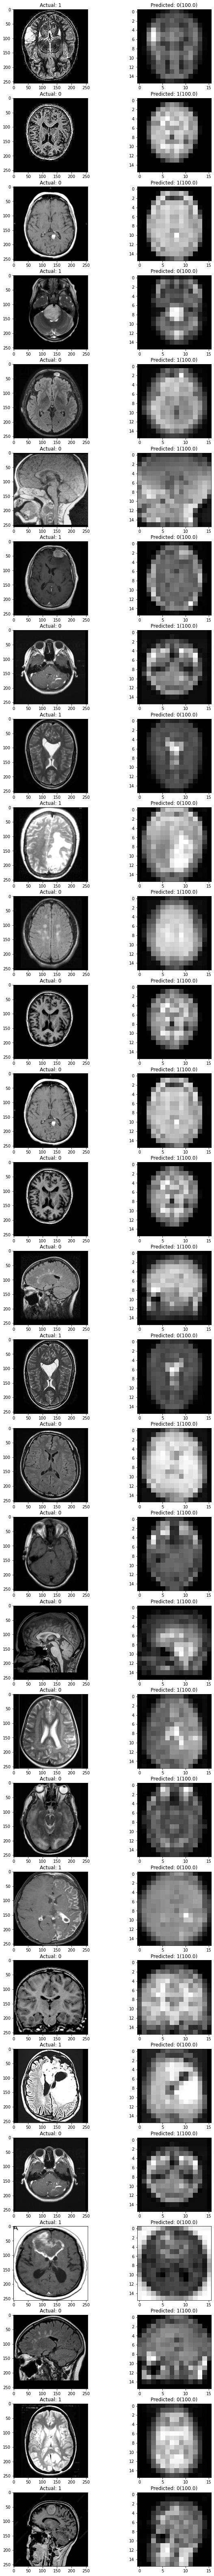

In [6]:
fig,axes = plt.subplots(nrows=len(misclassified_images),ncols=2,figsize=(10,int(len(misclassified_images)*4)))
for num in range(len(misclassified_images)):
    axes[num][0].imshow(np.array(misclassified_images.iloc[num]).reshape(256,256),cmap='gray')
    axes[num][1].imshow(np.array(misclassified_preprocessed_images.iloc[num]).reshape(int(np.sqrt(misclassified_preprocessed_images.shape[1])),
                                                                                      int(np.sqrt(misclassified_preprocessed_images.shape[1]))),cmap='gray')
    axes[num][0].set_title('Actual: ' + str(misclassified_labels.iloc[num]))
    if misclassified_labels.iloc[num] == 0:
        axes[num][1].set_title('Predicted: ' + str(abs(misclassified_labels.iloc[num] - 1)) + '(' + str(round(100*misclassified_probabilities[num],2)) + ')')
    else:
        axes[num][1].set_title('Predicted: ' + str(abs(misclassified_labels.iloc[num] - 1)) + '(' + str(round(100 - 100*misclassified_probabilities[num],2)) + ')')